# Contents:
**Part 0: Setting up an environment**
 - <a href="#C1">Importation of libraries</a>
 - <a href="#C2">Definition of functions</a>
 - <a href="#C3">Dataset import</a>
 
**Part 1: Data Analysis**
 - <a href="#C4">Dataset overview and initial cleaning</a>
 - <a href="#C5">Target Analysis</a>
 - <a href="#C6">Creating a simple dataset</a>
 - <a href="#C7">Creating a dataset from the Kernel</a>

**Part 2: Modeling**
 - <a href="#C8">Sampling and Data separation</a>
 - <a href="#C9">Pre-processing and modeling</a>
 - <a href="#C10">Gain optimisation</a>
 - <a href="#C11">Model interpretability </a>
 
**Part 3: Dashboard**
 - <a href="#C12">Model deployment</a>

# Part 0: Setting up the environment

# <a name="C1">Import of Libraries</a>

In [1]:
# Importing libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
import missingno as msno

import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()

import pickle

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import gc
import time

from contextlib import contextmanager

from lightgbm import LGBMClassifier
import sklearn as skl
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, auc, fbeta_score, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re

import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition, preprocessing
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling  import RandomUnderSampler

from collections import Counter

import math

import lightgbm as lgb
from lightgbm import LGBMClassifier
import re

import shap

C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\najwa\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\najwa\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas

In [2]:
# Displaying versions libraries used
print("pandas version : " + pd.__version__)
print("numpy version : " + np.__version__)
print("matplotlib version : " + mp.__version__)
print("seaborn version : " + sns.__version__)
print("sklearn version : " + skl.__version__)

pandas version : 1.4.2
numpy version : 1.21.5
matplotlib version : 3.5.1
seaborn version : 0.11.2
sklearn version : 1.0.2


# <a name="C2">Defining Functions</a>

In [3]:
PATH = "Data/"

In [4]:
sampler_list = [RandomUnderSampler(random_state=14), SMOTE(random_state=14)] 
    
scaler_list = [MinMaxScaler(feature_range=(0, 1)), StandardScaler(), RobustScaler()]                                         

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
def one_hot_encoder(df, nan_as_category = True):
    '''Fonction du kernel Kaggle'''  
    '''One-hot encoding for categorical columns with get_dummies '''                               

    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
def application_train_test(num_rows = None, nan_as_category = False):
    '''Fonction du kernel Kaggle''' 
    '''Preprocess application_train.csv and application_test.csv '''    
    
    # Read data and merge
    df = pd.read_csv(PATH+'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(PATH+'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [8]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''  
    '''Preprocess bureau.csv and bureau_balance.csv '''   
    
    bureau = pd.read_csv(PATH+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(PATH+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [9]:
def previous_applications(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''    
    '''Preprocess previous_applications.csv ''' 
    
    prev = pd.read_csv(PATH+'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [10]:
def pos_cash(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''     
    '''Preprocess POS_CASH_balance.csv '''
    
    pos = pd.read_csv(PATH+'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [11]:
def installments_payments(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''     
    '''Preprocess installments_payments.csv '''
    
    ins = pd.read_csv(PATH+'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [12]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''  
    '''Preprocess credit_card_balance.csv '''   
    
    cc = pd.read_csv(PATH+'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [13]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    '''Fonction du kernel Kaggle'''  
    '''LightGBM GBDT with KFold or Stratified KFold '''
    '''Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code'''
    
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [14]:
def display_importances(feature_importance_df_):
    '''Fonction du kernel Kaggle'''     
    '''Display/plot feature importance '''
    
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [15]:
def main(debug = False): 
    '''Fonction du kernel Kaggle'''   
    '''Main'''  
    
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    
    return df

In [16]:
def undersampling_manuel(X_train, y_train):
    '''Function for manual class balancing'''                                 

    targ1 = y_train[y_train==1].index
    targ0 = y_train[y_train==0].sample(len(targ1)).index
    
    samp_ind = list(set(list(targ0)+list(targ1)))
    
    X_tr_undersamp = X_train.loc[samp_ind]
    y_tr_undersamp = y_train.loc[samp_ind]
    
    return X_tr_undersamp, y_tr_undersamp

In [17]:
from imblearn.pipeline import Pipeline
def modelisation_with_sampler(X_train, y_train, sampler_type, estimator):
    '''Pre-treatment function that returns for an algo, the result of the different pre-treatments - with sampler'''                                 
                                               
    param_grid = {
        'sampler' : sampler_list,
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('sampler', RandomUnderSampler(random_state=14)),
        ('scaler', MinMaxScaler(feature_range=(0, 1))), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring="roc_auc")

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['sampler_type'] = sampler_type
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','sampler_type','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [18]:
from imblearn.pipeline import Pipeline
def modelisation_no_sampler(X_train, y_train, sampler_type, estimator):
    '''Pre-treatment function that returns for an algo, the result of the different pre-treatments - without sampler'''                                 
                                               
    param_grid = {
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('scaler', MinMaxScaler(feature_range=(0, 1))), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring="roc_auc")

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['sampler_type'] = sampler_type
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','sampler_type','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [19]:
def modelisation_baseline(X_train, y_train, sampler_type, estimator):
    '''Pre-treatment function that returns for an algo, the result of the different pre-treatments - for baseline'''                                 
                                               
    param_grid = {
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('scaler', StandardScaler()), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3)

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['sampler_type'] = sampler_type
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','sampler_type','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [20]:
from imblearn.pipeline import Pipeline
def optimisation_modele(X_train, y_train, estimator):
    '''Function that optimises LGBM hyperparameters'''
                                                
    param_grid = {
        'n_estimators' : [1000, 5000, 10000],
        'learning_rate' : [1, 0.1, 0.01] 
        }
        
    grid = GridSearchCV(estimator, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring="roc_auc", return_train_score = True)

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [21]:
def matrice_roc_auc(y_true, y_pred, y_pred_proba, size):
    '''Function that displays the confusion matrix and ROC/AUC, and returns the predictions'''

    fig = plt.figure(figsize=size)
  
    #Afficher matric de confusion
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Matrice de confusion')
    cf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #labels = ['Classe: 0', 'Classe: 1']
    
    sns.heatmap(cf_matrix, annot=labels, fmt="")
    
    #Afficher AUC/ROC
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba[:,1])    #pour la courbe ROC utilisation de la probabiilité d'être 1
    plt.plot(fpr, tpr, color='darkgreen', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()

    return tn, fp, fn, tp

In [22]:
def gain_banque(TN, FP, FN, TP, coeff_TN, coeff_FP, coeff_FN, coeff_TP):
    '''Cost function or gain function of the bank, depending on the predictions and associated cost/profit coeff'''

    gain = (coeff_TN*TN + coeff_FP*FP + coeff_FN*FN + coeff_TP*TP)

    # Calculation of maximum gain
    max_gain = (TN + FP)*coeff_TN 

    # Calculation of the minimum gain
    min_gain = (TP + FN)*coeff_FN

    # Normalisation of gain function: 
    f_gain = (gain - min_gain)/(max_gain - min_gain)

    return f_gain

# <a name="C3">Dataset import</a>

In [23]:
# Importing 9 files that make up the dataset
df_test = pd.read_csv(PATH+'application_test.csv')
df_train = pd.read_csv(PATH+'application_train.csv')
df_train_or = df_train.copy()
bureau = pd.read_csv(PATH+'bureau.csv')
bureau_balance = pd.read_csv(PATH+'bureau_balance.csv')
previous_app = pd.read_csv(PATH+'previous_application.csv')
homecredit_desc = pd.read_csv(PATH+'HomeCredit_columns_description.csv', encoding = "ISO-8859-1")
sampl_submission = pd.read_csv(PATH+'sample_submission.csv')
cash_balance = pd.read_csv(PATH+'POS_CASH_balance.csv')
cc_balance = pd.read_csv(PATH+'credit_card_balance.csv')
inst_payments = pd.read_csv(PATH+'installments_payments.csv')

In [24]:
# Creating lists
df_liste = [df_test, df_train, bureau, bureau_balance, previous_app, homecredit_desc, sampl_submission, cash_balance, cc_balance, inst_payments]
df_noms = ['df_test', 'df_train', 'bureau', 'bureau_balance', 'previous_app', 'homecredit_desc', 'sampl_submission', 'cash_balance', 'cc_balance', 'inst_payments']

# Part 1: Data Analysis

# <a name="C4" > Initial File Scan and Cleanup</a>

In [25]:
# Displaying the first 2 lines to ensure import.
for df, nom in zip(df_liste, df_noms):
    print(nom, ':')
    display(df.head(2))
    print('\n')

df_test :


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0




df_train :


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0




bureau :


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN




bureau_balance :


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C




previous_app :


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0




homecredit_desc :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN




sampl_submission :


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5




cash_balance :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0




cc_balance :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0




inst_payments :


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525


In [26]:
# Displaying the size of each file
for df, nom in zip(df_liste, df_noms):
    print(nom, ':', df.shape)

df_test : (48744, 121)
df_train : (307511, 122)
bureau : (1716428, 17)
bureau_balance : (27299925, 3)
previous_app : (1670214, 37)
homecredit_desc : (219, 5)
sampl_submission : (48744, 2)
cash_balance : (10001358, 8)
cc_balance : (3840312, 23)
inst_payments : (13605401, 8)


In [27]:
# Displaying columns
for df, nom in zip(df_liste, df_noms):
    print(nom, ':')
    display(df.info())

df_test :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


None

df_train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

bureau :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


None

bureau_balance :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


None

previous_app :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT          

None

homecredit_desc :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


None

sampl_submission :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


None

cash_balance :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


None

cc_balance :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INST

None

inst_payments :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


None

In [28]:
# Searching duplicates
for df, nom in zip(df_liste, df_noms):
    print(nom, df.duplicated().sum())

df_test 0
df_train 0
bureau 0
bureau_balance 0
previous_app 0
homecredit_desc 0
sampl_submission 0
cash_balance 0
cc_balance 0
inst_payments 0


In [29]:
# Displaying missing data for each file (% of NaNs)
for df, nom in zip(df_liste, df_noms):
    print(nom, df.isna().mean().mean())

df_test 0.23811686761532344
df_train 0.24395941907129431
bureau 0.13502552290879322
bureau_balance 0.0
previous_app 0.17976877473444977
homecredit_desc 0.12146118721461188
sampl_submission 0.0
cash_balance 0.0006518864738168557
cc_balance 0.0665407439268748
inst_payments 5.337953655316738e-05


# <a name="C5">Target analysis</a>

In [30]:
# Displaying number of clients in each category
df_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

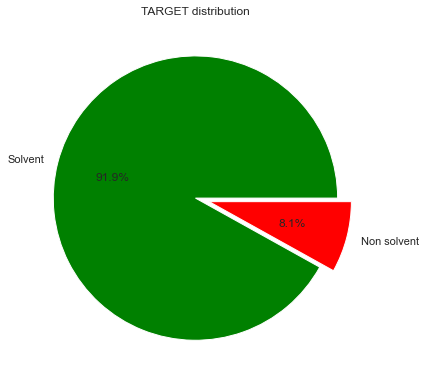

In [31]:
# Visualising the target distribution
y = ['Solvent', 'Non solvent']
x = df_train["TARGET"].value_counts()
colors_list = ['green', 'red']
explode_val = (0,0.1)
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(x, labels = y, autopct ='%.1f%%', explode = explode_val, colors = colors_list)
ax.set_title("TARGET distribution")
plt.tight_layout()

# <a name="C6">Creating a simple dataset</a>

In [32]:
# Displaying the first 2 lines
df_train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Displaying the file size
df_train.shape

(307511, 122)

In [34]:
# Displaying the columns
print(list(df_train.columns))

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

In [35]:
# Dislaying the features per type
df_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [36]:
# Deleting the categorial columns
df_train.drop(df_train.select_dtypes('object').columns,1,inplace=True)

In [37]:
# Displaying missing data
df_train.isna().mean()

SK_ID_CURR                    0.000000
TARGET                        0.000000
CNT_CHILDREN                  0.000000
AMT_INCOME_TOTAL              0.000000
AMT_CREDIT                    0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
Length: 106, dtype: float64

<AxesSubplot:>

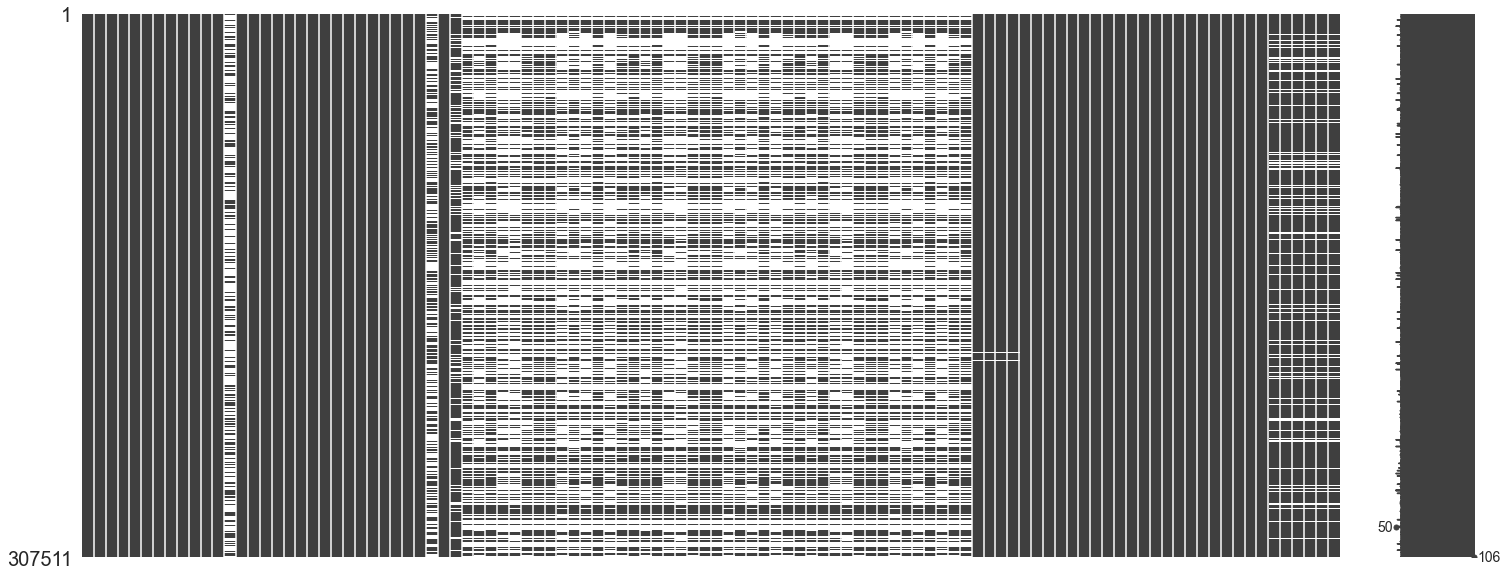

In [38]:
# Displaying missing data for the file app (% of NaNs)
msno.matrix(df_train)

In [39]:
# Deleting features with more than 10% NaN
df_train = df_train[df_train.columns[df_train.isna().sum()/df_train.shape[0]<0.1]]
df_train.shape

(307511, 54)

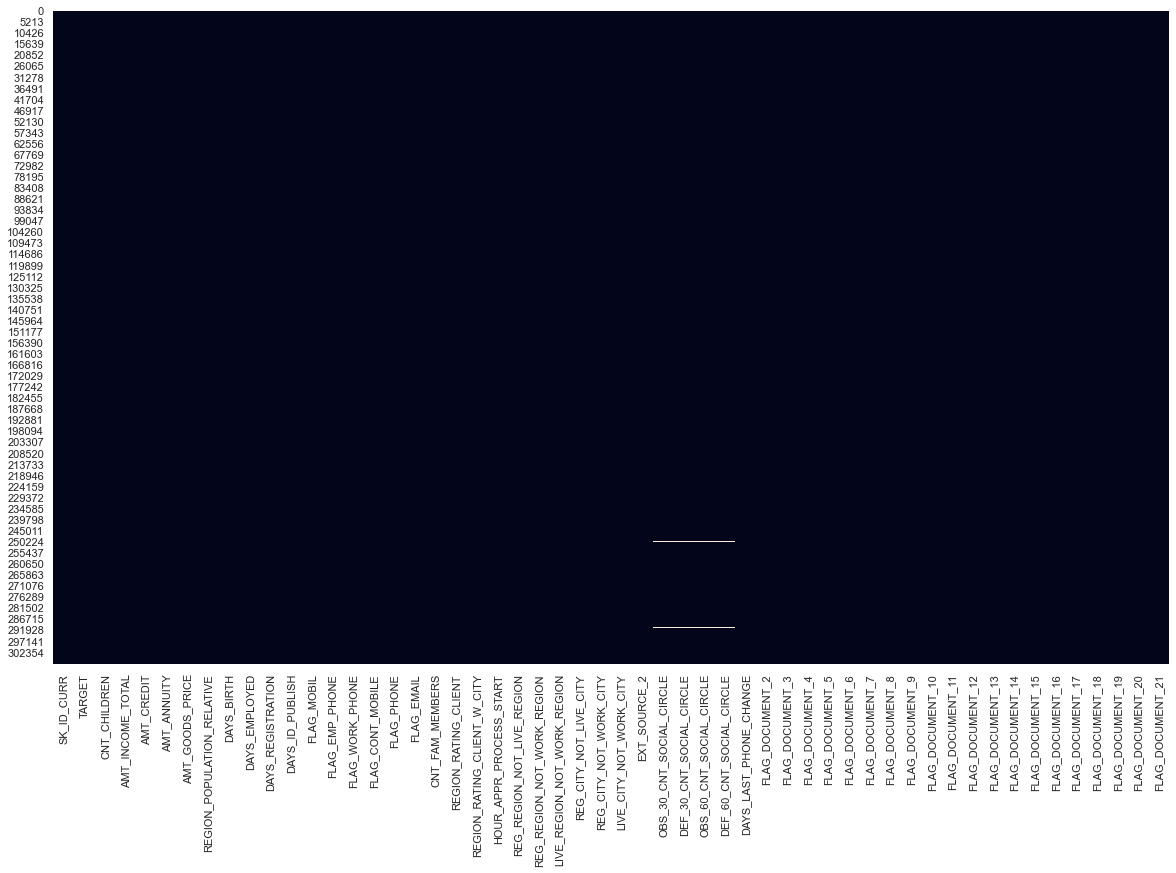

In [40]:
# Visualising missing data
plt.figure(figsize=(20,12))
sns.heatmap(df_train.isna(), cbar= False)
plt.show()

In [41]:
# Displaying stats on features
pd.pandas.set_option('display.max_columns', None)
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.068510e+05,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,5.143927e-01,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,1.910602e-01,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.173617e-08,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.924574e-01,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-325

In [42]:
# Analysing and visualising Target and features with outliers
COL_TARGET = ['TARGET']
COL_FEATURES_AB = ['AMT_INCOME_TOTAL','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']
COL = COL_TARGET + COL_FEATURES_AB
COL

['TARGET',
 'AMT_INCOME_TOTAL',
 'AMT_ANNUITY',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

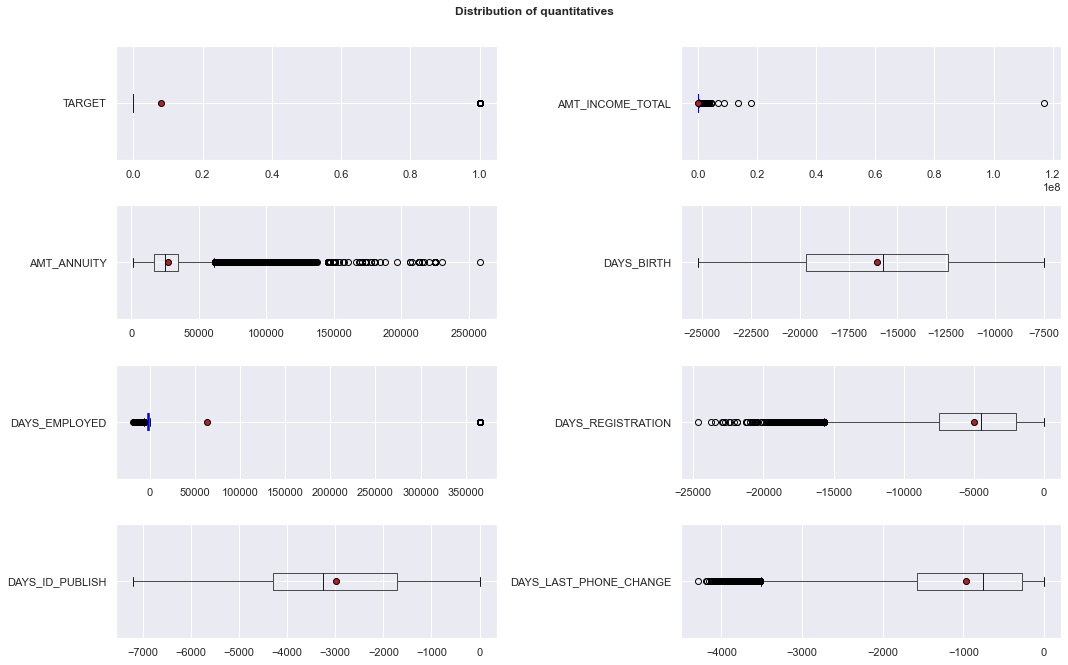

In [43]:
# Analysing boxplot for each feature
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(5,2,i)
    data_temp = df_train[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

In [44]:
# Identifying outliers in AMT_INCOME
df_train[df_train.AMT_INCOME_TOTAL>1e8]

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
12840,114967,1,1,117000000.0,562491.0,26194.5,454500.0,0.010643,-12615,-922,-6762.0,-3643,1,1,0,1,0,0,3.0,2,2,14,0,0,0,0,0,0,0.113161,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# Deleting this outlier given its low occurence
df_train = df_train[df_train.AMT_INCOME_TOTAL<1e8]

In [46]:
# Identifying outliers in DAYS_EMPLOYED
OUT = df_train[df_train['DAYS_EMPLOYED'] > 300000]
OUT['DAYS_EMPLOYED']

8         365243
11        365243
23        365243
38        365243
43        365243
           ...  
307469    365243
307483    365243
307487    365243
307505    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 55374, dtype: int64

In [47]:
# Updating the outlier in NaN given the number of occurrences
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243,np.nan)

In [48]:
# Changing DAYS_BIRTH from day to year
df_train['DAYS_BIRTH'] = df_train['DAYS_BIRTH'] / -365
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'] / -365
df_train['DAYS_REGISTRATION'] = df_train['DAYS_REGISTRATION'] / -365
df_train['DAYS_ID_PUBLISH'] = df_train['DAYS_ID_PUBLISH'] / -365
df_train['DAYS_LAST_PHONE_CHANGE'] = df_train['DAYS_LAST_PHONE_CHANGE'] / -365
df_train['AMT_ANNUITY'] = df_train['AMT_ANNUITY'] 

In [49]:
# Displaying dataset size
df_train.shape

(307510, 54)

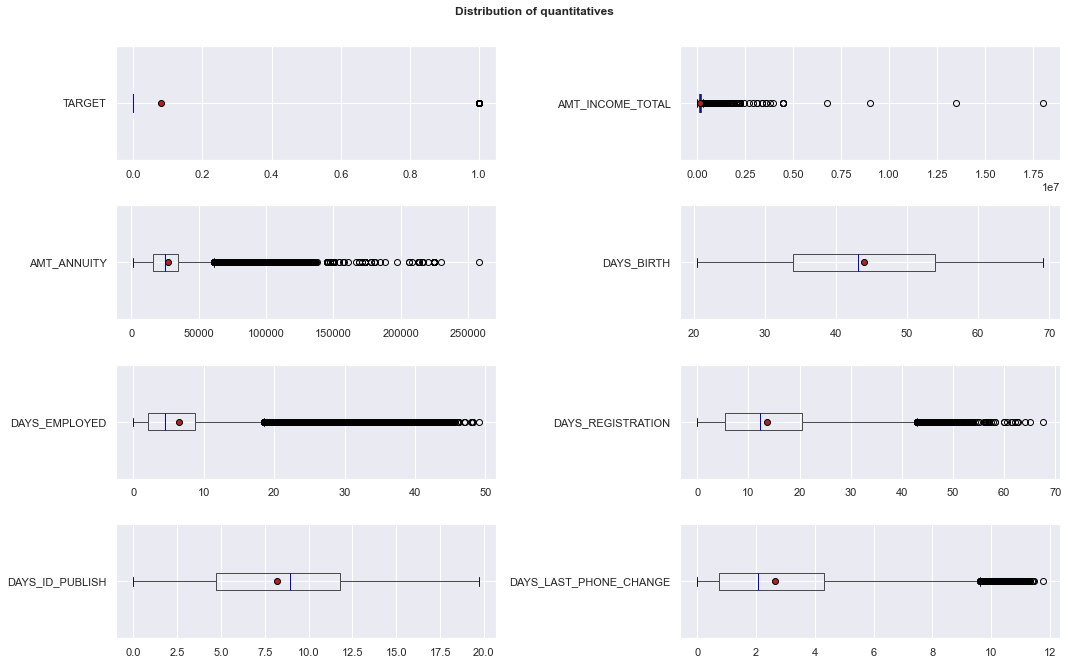

In [50]:
# Analysing boxplot for each feature
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(5,2,i)
    data_temp = df_train[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

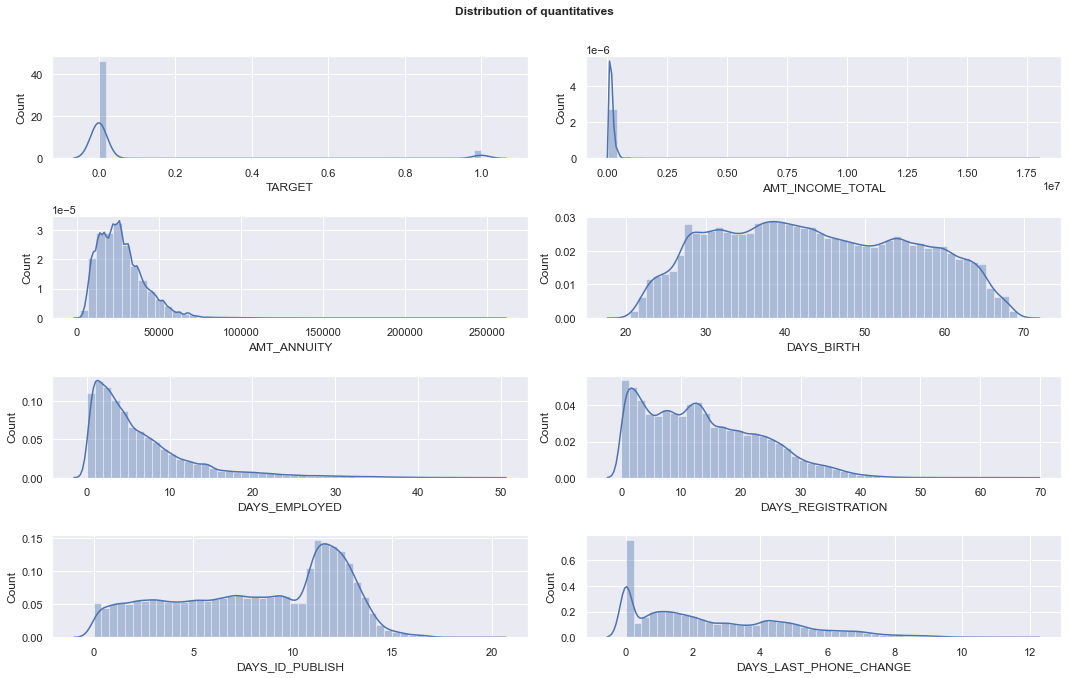

In [51]:
# Analysing boxplot for each feature
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(5,2,i)
    sns.distplot(df_train[col])
    plt.xlabel(col)
    plt.ylabel("Count")
    
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

In [52]:
# Deleting lines with a NaN
df_train = df_train.dropna()
df_train.shape

(250518, 54)

In [53]:
# Displaying columns
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FL

In [54]:
# Deleting columns no longer needed
df_train['NB_DOCUMENTS']=(df_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]==1).sum(axis=1)
df_train.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],1, inplace=True)

In [55]:
# Suming contact flag variables
df_train['NB_CONTACTS']=((df_train[['FLAG_MOBIL',
                            'FLAG_EMP_PHONE',
                            'FLAG_WORK_PHONE',
                            'FLAG_CONT_MOBILE',
                            'FLAG_PHONE',
                            'FLAG_EMAIL'
                           ]]).sum(axis=1))
df_train.drop(['FLAG_MOBIL',
                            'FLAG_EMP_PHONE',
                            'FLAG_WORK_PHONE',
                            'FLAG_CONT_MOBILE',
                            'FLAG_PHONE',
                            'FLAG_EMAIL'],1, inplace=True)

In [56]:
# Calcuting the mean for few variables
df_train['MEAN_DEFAULT_OBS']=((df_train[['OBS_30_CNT_SOCIAL_CIRCLE',
                                  'DEF_30_CNT_SOCIAL_CIRCLE',
                                  'OBS_60_CNT_SOCIAL_CIRCLE',
                                  'DEF_60_CNT_SOCIAL_CIRCLE'
                                 ]]).mean(axis=1))//4
df_train.drop(['OBS_30_CNT_SOCIAL_CIRCLE',
                                  'DEF_30_CNT_SOCIAL_CIRCLE',
                                  'OBS_60_CNT_SOCIAL_CIRCLE',
                                  'DEF_60_CNT_SOCIAL_CIRCLE'],1, inplace=True)

In [57]:
# Suming the address variables
df_train['NB_ADDRESS_MISSMATCH']=((df_train[['REG_REGION_NOT_LIVE_REGION',
                                  'REG_REGION_NOT_WORK_REGION',
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY']]).sum(axis=1))
df_train.drop(['REG_REGION_NOT_LIVE_REGION',
                                  'REG_REGION_NOT_WORK_REGION',
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY'],1, inplace=True)

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 1080x864 with 0 Axes>

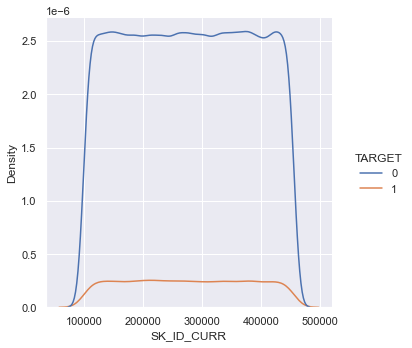

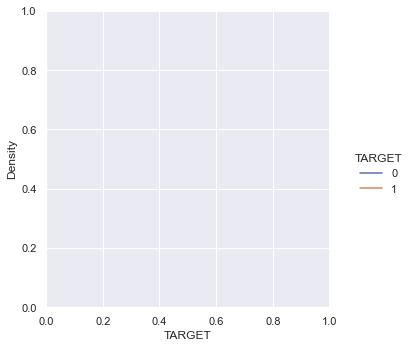

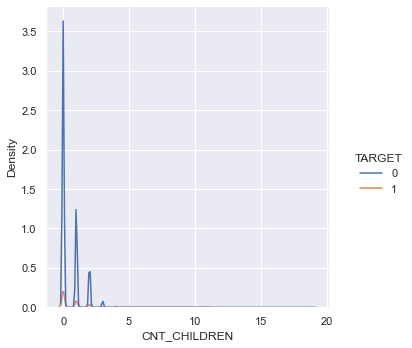

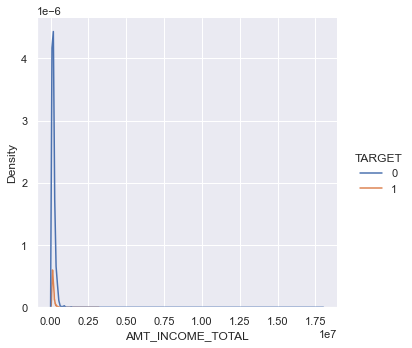

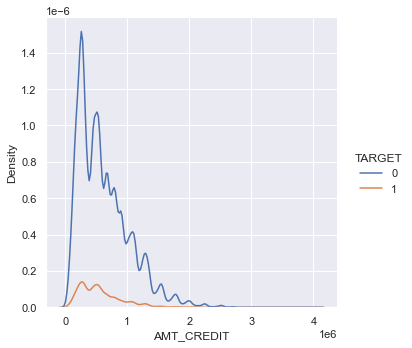

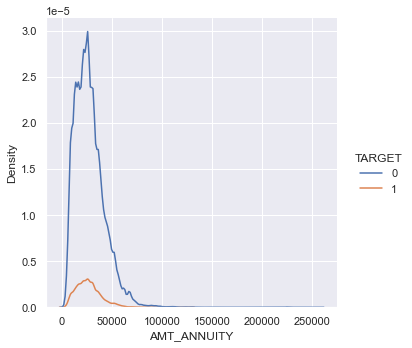

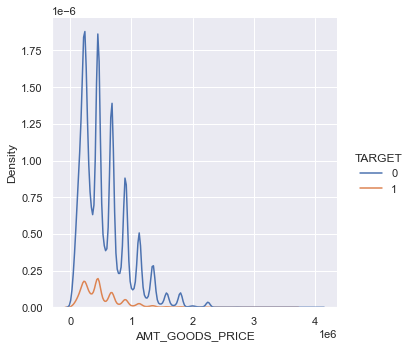

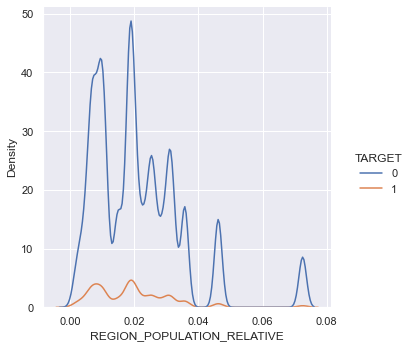

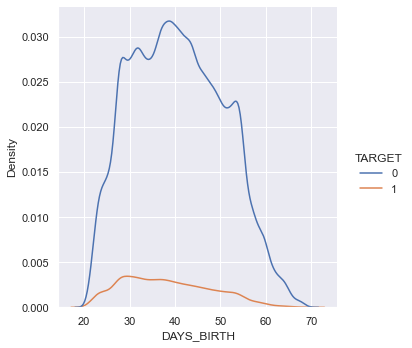

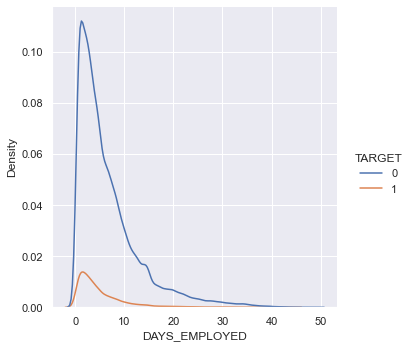

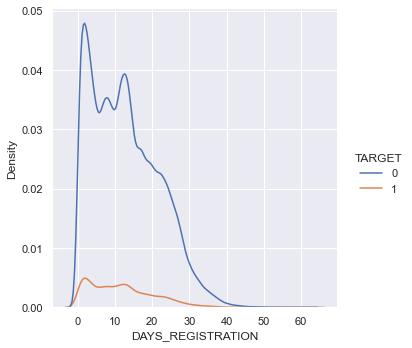

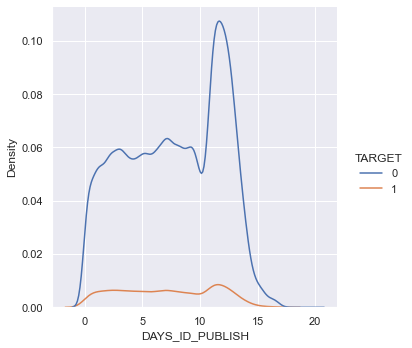

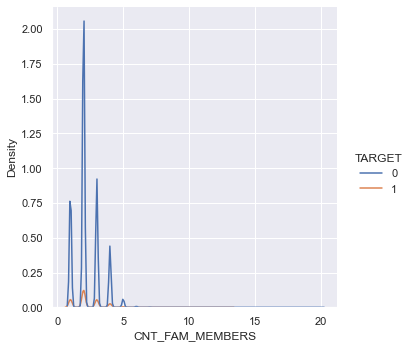

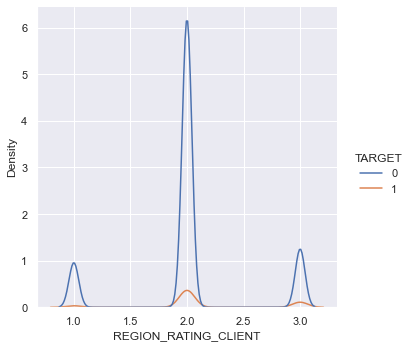

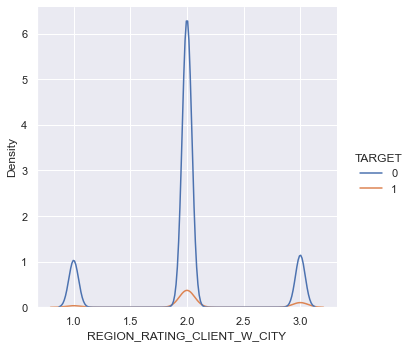

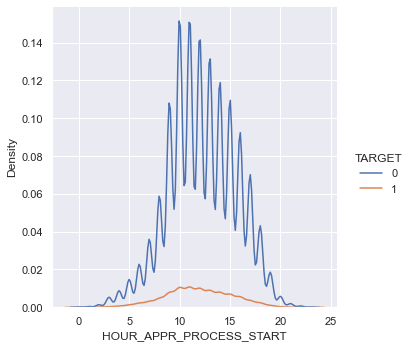

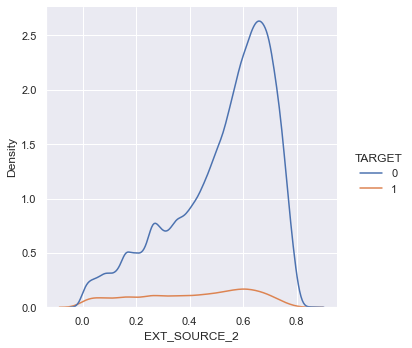

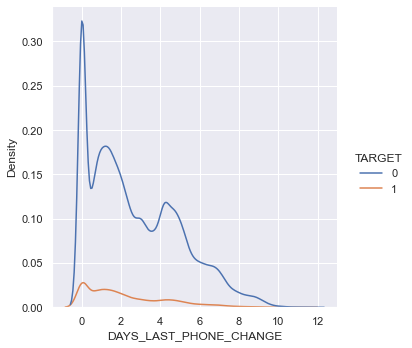

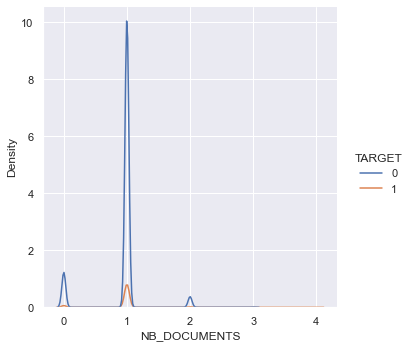

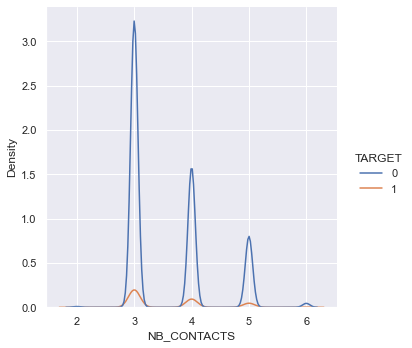

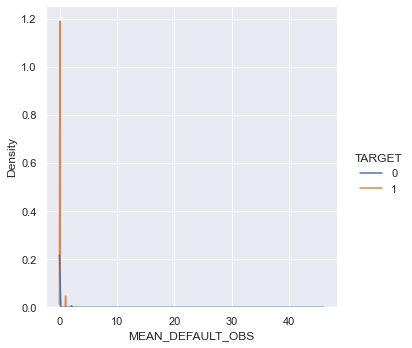

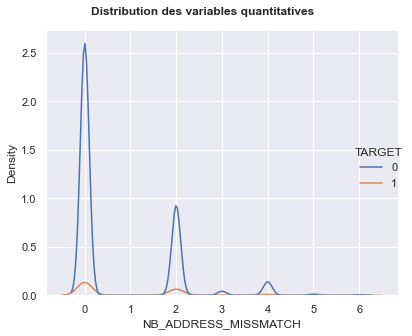

In [58]:
# Analysing orders of magnitude for each target variable of our mission
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

COL = df_train.columns

for i, col in enumerate(COL,1):
    #ax = fig.add_subplot(6,3,i)
    sns.displot(data=df_train, x=col, hue="TARGET", kind="kde")

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution des variables quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


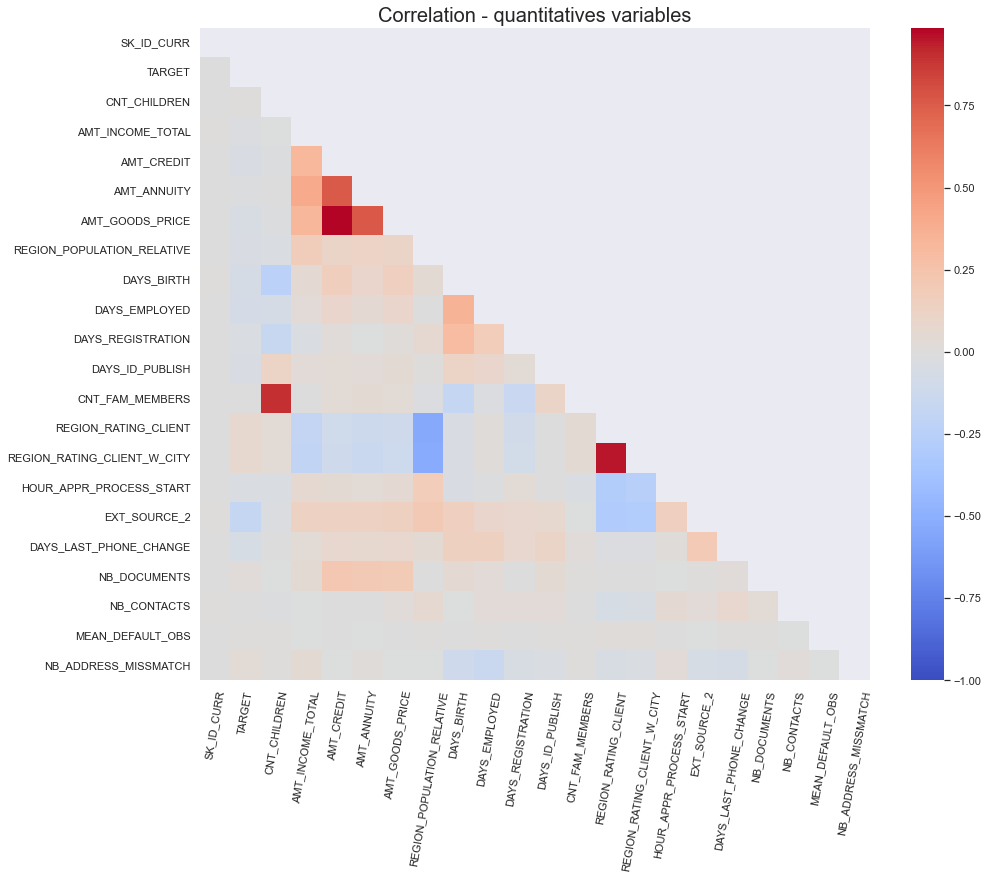

In [59]:
# Visualising heatmap correlation between quantitatives variables
plt.figure(figsize=(15,12))
#sns.set(font_scale=1.5)
plt.title('Correlation - quantitatives variables', fontsize = 20)

corr = df_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm', annot = False)
plt.xticks(rotation=80)
plt.show()
sns.set(font_scale=1)

In [60]:
# Analysing variables with high correlation for decision making
df_train[['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']].describe()

,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
count,250518.000000,250518.000000
mean,2.045258,2.023918
std,0.512262,0.506336
min,1.000000,1.000000
25%,2.000000,2.000000
50%,2.000000,2.000000
75%,2.000000,2.000000
max,3.000000,3.000000


In [61]:
# Deletion of one of the 2 variables due to equivalent distribution
df_train.drop(['REGION_RATING_CLIENT_W_CITY'],1, inplace=True)

In [62]:
# Analysing variables with high correlation for decision making
df_train[['CNT_FAM_MEMBERS','CNT_CHILDREN']].describe()

,CNT_FAM_MEMBERS,CNT_CHILDREN
count,250518.000000,250518.000000
mean,2.252868,0.498563
std,0.942067,0.763292
min,1.000000,0.000000
25%,2.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,1.000000
max,20.000000,19.000000


In [63]:
# Creating new "industry related" variables and removing one of the 2 highly correlated variables
df_train['INCOME_PER_PERSON'] = df_train['AMT_INCOME_TOTAL'] / (df_train['CNT_FAM_MEMBERS'])

In [64]:
# Deletion of one of the 2 variables due to equivalent distribution
df_train.drop(['CNT_FAM_MEMBERS','AMT_INCOME_TOTAL'],1, inplace=True)

In [65]:
# Creating new "industry related" variables and removing one of the 2 highly correlated variables
df_train['CREDIT_PER_GOOD']=df_train['AMT_CREDIT']/df_train['AMT_GOODS_PRICE']
df_train['ANNUITY_PER_GOOD']=df_train['AMT_ANNUITY']/df_train['AMT_GOODS_PRICE']
df_train['YRS_WORKING_PER_BIRTH']=df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']

In [66]:
# Deletion of correlated and unecessary variables
df_train.drop(['DAYS_EMPLOYED','DAYS_BIRTH','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_CHILDREN'],1, inplace=True)

In [67]:
# Displaying size of new dataframe
df_train.shape

(250518, 17)

In [68]:
# Selecting best features with VIF - Variance Inflation Factor
df_train_vif = df_train.copy()
X = df_train_vif.drop(['SK_ID_CURR','TARGET'], axis=1)

vif_info = pd.DataFrame()

vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
12,49.560987,CREDIT_PER_GOOD
8,20.205251,NB_CONTACTS
3,18.975556,REGION_RATING_CLIENT
4,14.197000,HOUR_APPR_PROCESS_START
5,9.177337,EXT_SOURCE_2
7,8.371645,NB_DOCUMENTS
13,6.917681,ANNUITY_PER_GOOD
2,4.469107,DAYS_ID_PUBLISH
0,4.286112,REGION_POPULATION_RELATIVE
1,3.100660,DAYS_REGISTRATION


In [69]:
# Deleting variables with VIF higher than 5
df_train_vif.drop(['CREDIT_PER_GOOD','NB_CONTACTS','REGION_RATING_CLIENT','HOUR_APPR_PROCESS_START','EXT_SOURCE_2','NB_DOCUMENTS','ANNUITY_PER_GOOD'],1, inplace=True)

In [70]:
# Shwoing size of simple dataset
df_train_vif.shape

(250518, 10)

In [71]:
# Saving simple dataset
df_train_vif.to_csv('Dataset/df_train_simple.csv', index=False)

# <a name="C7">Creation d'un dataset basé sur le Kernel Kaggle</a>

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 28s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 41s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 22s
Installments payments df shape: (339587, 26)
Process installments payments - done in 49s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 19s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797104	training's binary_logloss: 0.234829	valid_1's auc: 0.776089	valid_1's binary_logloss: 0.246759
[400]	training's auc: 0.819226	training's binary_logloss: 0.22537	valid_1's auc: 0.787159	valid_1's binary_logloss: 0.242511
[600]	training's auc: 0.834155	training's binary_logloss: 0.219277	valid_1's auc: 0.790742	valid_1's binary_logloss: 0.241208
[800]	training's auc: 0.846219	training's binary_logloss: 0.214311	valid_1's auc: 0.792638	valid_1's binary_logloss: 0.240572
[1000]	training's auc: 0.856646	training's binary_logloss: 0.20991	valid_1's auc: 0.793314	valid_1's binary_logloss: 0.240345
[1200]	training's auc: 0.866329	training's binary_logloss: 0.205763	valid_1's auc: 0.794016	valid_1's binary_logloss: 0.240111
[1400]	training's auc: 0.875268	training's binary_logloss: 0.2017	valid_1's auc: 0.794374	valid_1's binary_logloss: 0.240002
[1600]

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796504	training's binary_logloss: 0.235573	valid_1's auc: 0.777058	valid_1's binary_logloss: 0.241702
[400]	training's auc: 0.819063	training's binary_logloss: 0.226043	valid_1's auc: 0.786754	valid_1's binary_logloss: 0.237454
[600]	training's auc: 0.833962	training's binary_logloss: 0.21997	valid_1's auc: 0.788941	valid_1's binary_logloss: 0.236447
[800]	training's auc: 0.846139	training's binary_logloss: 0.214955	valid_1's auc: 0.790289	valid_1's binary_logloss: 0.235906
[1000]	training's auc: 0.856195	training's binary_logloss: 0.210675	valid_1's auc: 0.790743	valid_1's binary_logloss: 0.235667
[1200]	training's auc: 0.865472	training's binary_logloss: 0.206638	valid_1's auc: 0.79094	valid_1's binary_logloss: 0.23555
[1400]	training's auc: 0.874355	training's binary_logloss: 0.202693	valid_1's auc: 0.791202	valid_1's binary_logloss: 0.235424
[1600

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797097	training's binary_logloss: 0.235026	valid_1's auc: 0.76787	valid_1's binary_logloss: 0.246536
[400]	training's auc: 0.819952	training's binary_logloss: 0.225433	valid_1's auc: 0.778311	valid_1's binary_logloss: 0.242546
[600]	training's auc: 0.834998	training's binary_logloss: 0.219239	valid_1's auc: 0.781675	valid_1's binary_logloss: 0.241422
[800]	training's auc: 0.8474	training's binary_logloss: 0.214093	valid_1's auc: 0.783594	valid_1's binary_logloss: 0.240809
[1000]	training's auc: 0.857595	training's binary_logloss: 0.209775	valid_1's auc: 0.784536	valid_1's binary_logloss: 0.240494
[1200]	training's auc: 0.866985	training's binary_logloss: 0.205683	valid_1's auc: 0.785113	valid_1's binary_logloss: 0.240377
[1400]	training's auc: 0.875537	training's binary_logloss: 0.201832	valid_1's auc: 0.785241	valid_1's binary_logloss: 0.240407
Fold 

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796781	training's binary_logloss: 0.23554	valid_1's auc: 0.778094	valid_1's binary_logloss: 0.241263
[400]	training's auc: 0.81928	training's binary_logloss: 0.225978	valid_1's auc: 0.788498	valid_1's binary_logloss: 0.236955
[600]	training's auc: 0.834386	training's binary_logloss: 0.219837	valid_1's auc: 0.792236	valid_1's binary_logloss: 0.235482
[800]	training's auc: 0.846366	training's binary_logloss: 0.214924	valid_1's auc: 0.793725	valid_1's binary_logloss: 0.23491
[1000]	training's auc: 0.857037	training's binary_logloss: 0.210442	valid_1's auc: 0.794901	valid_1's binary_logloss: 0.234455
[1200]	training's auc: 0.8665	training's binary_logloss: 0.206311	valid_1's auc: 0.795161	valid_1's binary_logloss: 0.234325
[1400]	training's auc: 0.875286	training's binary_logloss: 0.202334	valid_1's auc: 0.795642	valid_1's binary_logloss: 0.234145
[1600]	

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796443	training's binary_logloss: 0.236317	valid_1's auc: 0.78032	valid_1's binary_logloss: 0.234124
[400]	training's auc: 0.819068	training's binary_logloss: 0.226741	valid_1's auc: 0.790482	valid_1's binary_logloss: 0.229854
[600]	training's auc: 0.833992	training's binary_logloss: 0.220619	valid_1's auc: 0.793639	valid_1's binary_logloss: 0.228569
[800]	training's auc: 0.846192	training's binary_logloss: 0.215603	valid_1's auc: 0.795317	valid_1's binary_logloss: 0.227936
[1000]	training's auc: 0.856531	training's binary_logloss: 0.211213	valid_1's auc: 0.796348	valid_1's binary_logloss: 0.22756
[1200]	training's auc: 0.866038	training's binary_logloss: 0.207091	valid_1's auc: 0.797078	valid_1's binary_logloss: 0.227334
[1400]	training's auc: 0.874456	training's binary_logloss: 0.203282	valid_1's auc: 0.797234	valid_1's binary_logloss: 0.227263
[160

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797404	training's binary_logloss: 0.235337	valid_1's auc: 0.76717	valid_1's binary_logloss: 0.243343
[400]	training's auc: 0.820012	training's binary_logloss: 0.225758	valid_1's auc: 0.778167	valid_1's binary_logloss: 0.239452
[600]	training's auc: 0.835049	training's binary_logloss: 0.219617	valid_1's auc: 0.782224	valid_1's binary_logloss: 0.238116
[800]	training's auc: 0.847157	training's binary_logloss: 0.214639	valid_1's auc: 0.783885	valid_1's binary_logloss: 0.237496
[1000]	training's auc: 0.857708	training's binary_logloss: 0.210211	valid_1's auc: 0.784889	valid_1's binary_logloss: 0.237139
[1200]	training's auc: 0.867254	training's binary_logloss: 0.205959	valid_1's auc: 0.785179	valid_1's binary_logloss: 0.236995
[1400]	training's auc: 0.876057	training's binary_logloss: 0.201915	valid_1's auc: 0.785234	valid_1's binary_logloss: 0.236983
Fol

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797268	training's binary_logloss: 0.235527	valid_1's auc: 0.774539	valid_1's binary_logloss: 0.240657
[400]	training's auc: 0.819627	training's binary_logloss: 0.225979	valid_1's auc: 0.784495	valid_1's binary_logloss: 0.236476
[600]	training's auc: 0.83472	training's binary_logloss: 0.219851	valid_1's auc: 0.787703	valid_1's binary_logloss: 0.235247
[800]	training's auc: 0.847018	training's binary_logloss: 0.21483	valid_1's auc: 0.78932	valid_1's binary_logloss: 0.234726
[1000]	training's auc: 0.85732	training's binary_logloss: 0.210487	valid_1's auc: 0.78994	valid_1's binary_logloss: 0.234503
[1200]	training's auc: 0.866926	training's binary_logloss: 0.206324	valid_1's auc: 0.790406	valid_1's binary_logloss: 0.234408
[1400]	training's auc: 0.875563	training's binary_logloss: 0.20244	valid_1's auc: 0.790384	valid_1's binary_logloss: 0.234439
Fold  7 

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797384	training's binary_logloss: 0.235077	valid_1's auc: 0.770478	valid_1's binary_logloss: 0.245343
[400]	training's auc: 0.819664	training's binary_logloss: 0.225542	valid_1's auc: 0.781776	valid_1's binary_logloss: 0.240982
[600]	training's auc: 0.834599	training's binary_logloss: 0.219451	valid_1's auc: 0.785968	valid_1's binary_logloss: 0.239525
[800]	training's auc: 0.846348	training's binary_logloss: 0.214629	valid_1's auc: 0.787951	valid_1's binary_logloss: 0.238904
[1000]	training's auc: 0.856847	training's binary_logloss: 0.210207	valid_1's auc: 0.788733	valid_1's binary_logloss: 0.238634
[1200]	training's auc: 0.866335	training's binary_logloss: 0.206035	valid_1's auc: 0.789318	valid_1's binary_logloss: 0.238496
[1400]	training's auc: 0.875156	training's binary_logloss: 0.202086	valid_1's auc: 0.789737	valid_1's binary_logloss: 0.238361
[1

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796262	training's binary_logloss: 0.235491	valid_1's auc: 0.780614	valid_1's binary_logloss: 0.242519
[400]	training's auc: 0.819304	training's binary_logloss: 0.225829	valid_1's auc: 0.7906	valid_1's binary_logloss: 0.238067
[600]	training's auc: 0.834369	training's binary_logloss: 0.219696	valid_1's auc: 0.794411	valid_1's binary_logloss: 0.236568
[800]	training's auc: 0.846365	training's binary_logloss: 0.214734	valid_1's auc: 0.795589	valid_1's binary_logloss: 0.235997
[1000]	training's auc: 0.857347	training's binary_logloss: 0.21016	valid_1's auc: 0.795693	valid_1's binary_logloss: 0.235837
[1200]	training's auc: 0.866959	training's binary_logloss: 0.20599	valid_1's auc: 0.796198	valid_1's binary_logloss: 0.235632
[1400]	training's auc: 0.876094	training's binary_logloss: 0.201939	valid_1's auc: 0.796356	valid_1's binary_logloss: 0.235572
[1600]

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796896	training's binary_logloss: 0.235586	valid_1's auc: 0.771623	valid_1's binary_logloss: 0.240838
[400]	training's auc: 0.819574	training's binary_logloss: 0.226061	valid_1's auc: 0.782718	valid_1's binary_logloss: 0.236567
[600]	training's auc: 0.834468	training's binary_logloss: 0.21995	valid_1's auc: 0.786322	valid_1's binary_logloss: 0.235229
[800]	training's auc: 0.846691	training's binary_logloss: 0.214993	valid_1's auc: 0.788052	valid_1's binary_logloss: 0.234624
[1000]	training's auc: 0.857452	training's binary_logloss: 0.210465	valid_1's auc: 0.789127	valid_1's binary_logloss: 0.234272
[1200]	training's auc: 0.867238	training's binary_logloss: 0.206246	valid_1's auc: 0.789493	valid_1's binary_logloss: 0.23412
[1400]	training's auc: 0.876043	training's binary_logloss: 0.202265	valid_1's auc: 0.789718	valid_1's binary_logloss: 0.23401
[1600

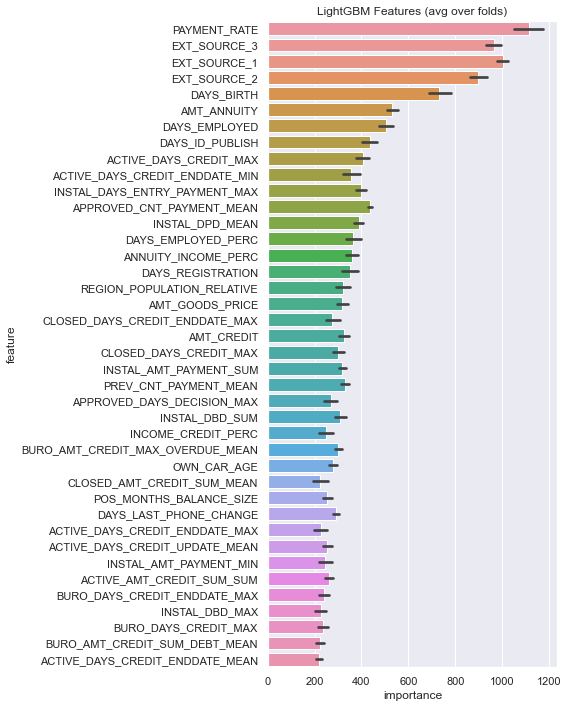

In [72]:
# Launching the Kaggle Kernel functions to obtain the complex dataset (more elaborate and thought)
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df_train_test_kernel = main()

In [73]:
# Displaying size of complex dataset
df_train_test_kernel.shape

(356251, 798)

In [74]:
# Displaying resulting file
df_train_test_kernel.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZ

In [75]:
# Saving complex dataset
df_train_test_kernel.to_csv('Dataset/df_train_test_kernel.csv', index=False)

# Part 2 : Modeling

In [76]:
# Loading kernel data
data = pd.read_csv('Dataset/df_train_test_kernel.csv')
data_name = 'KERNEL'

In [77]:
# Transforming column names without spaces or special features
data.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").replace(","," ").replace("["," ").replace("]"," ").replace("{"," ").replace("}"," ").replace(":"," ").upper(), data.columns))
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# <a name="C8">Sampling and Separation of Data to Train and Test</a>

In [78]:
# Sampling of data to 10%. Choice to take the first 30,000 from the list. IMPORTANT NOTE : choice to consider 30000 first rows as these rows represent well the overall dataset in terms of TARGET count. Otherwise, use of sample stratify on Target.
data = data.head(30000)
data.head()

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_CASH_LOANS,NAME_CONTRACT_TYPE_REVOLVING_LOANS,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_MATERNITY_LEAVE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_ACADEMIC_DEGREE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,NAME_HOUSING_TYPE_CO_OP_APARTMENT,NAME_HOUSING_TYPE_HOUSE_APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT,NAME_HOUSING_TYPE_OFFICE_APARTMENT,NAME_HOUSING_TYPE_RENTED_APARTMENT,NAME_HOUSING_TYPE_WITH_PARENTS,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CLEANING_STAFF,OCCUPATION_TYPE_COOKING_STAFF,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_IT_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_PRIVATE_SERVICE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITY_STAFF,OCCUPATION_TYPE_WAITERSBARMEN_STAFF,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ADVERTISING,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BANK,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_1,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_2,ORGANIZATION_TYPE

In [79]:
#Defining X(features) and y(TARGET) to split data
if data_name == 'KERNEL':
    train_df = data[data['TARGET'].notnull()]
    test_df = data[data['TARGET'].isnull()]
    #feats_kernel = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','index','PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']]
    #X=train_df[feats_kernel]
    y=train_df['TARGET']
    list_out = ['TARGET','PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']
       
    X = train_df.drop(columns = list_out) #on vire les colonnes infinies
else:
    feats = [f for f in data.columns if f not in ['TARGET','SK_ID_CURR']]
    X=data[feats]
    y=data['TARGET']

In [80]:
# Spliting data in training and testing with a ratio of 80 20
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=10)

# <a name="C9">Preprocessing and modeling</a>

### Baseline

In [81]:
# Initialising the Results dataframe that will contain the results of the modeling evaluations
results = pd.DataFrame()

In [82]:
# Evaluating modeling on a Dummy Classifier
result = modelisation_baseline(X_train, y_train, "no_sampler", DummyClassifier(strategy="most_frequent"))
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [83]:
# Evaluating modeling on a LogisticRegression
result = modelisation_baseline(X_train, y_train, "no_sampler", LogisticRegression())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [84]:
# Displaying the results - accuracy too good! Due to the unbalanced classes
results

,estimator,sampler_type,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
0,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': MinMaxScaler()},0.919417,9.361735,0.922,0.000,0.000,0.000,0.500
1,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': StandardScaler()},0.919417,10.606289,0.922,0.000,0.000,0.000,0.500
2,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': RobustScaler()},0.919417,6.562920,0.922,0.000,0.000,0.000,0.500
0,LogisticRegression(),no_sampler,{'scaler': MinMaxScaler()},0.918583,16.908044,0.921,0.459,0.036,0.067,0.753
1,LogisticRegression(),no_sampler,{'scaler': StandardScaler()},0.915333,14.797940,0.921,0.459,0.036,0.067,0.753
2,LogisticRegression(),no_sampler,{'scaler': RobustScaler()},0.634875,11.959026,0.921,0.459,0.036,0.067,0.753


To remedy this imbalance, 4 solutions are considered:
- undersampling created manually
- class weight balance
- SMOTE
- RandomUnderSampling

### Preprocessing with manuel undersampling

In [85]:
# Applying manual sub-sampling to our datasets
X_tr_under, y_tr_under = undersampling_manuel(X_train, y_train)

In [86]:
# Determining the number of clients per class
y_tr_under.value_counts()

1.0    1934
0.0    1934
Name: TARGET, dtype: int64

In [87]:
# Evaluating and optimising preprocessing parameters on algo LogisticRegression
result = modelisation_no_sampler(X_tr_under, y_tr_under, "manual_sampler", LogisticRegression())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [88]:
# Evaluating and optimising preprocessing parameters on algo KNN
result = modelisation_no_sampler(X_tr_under, y_tr_under, "manual_sampler", KNeighborsClassifier())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [89]:
# Evaluating and optimising preprocessing parameters on algo LGBM
result = modelisation_no_sampler(X_tr_under, y_tr_under, "manual_sampler", LGBMClassifier())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


### Preprocessing with class weight balanced

In [90]:
# Evaluating and optimising preprocessing parameters on algo LogisticRegression
result = modelisation_no_sampler(X_train, y_train, "class_balanced", LogisticRegression(class_weight='balanced'))
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [91]:
# Evaluating and optimising preprocessing parameters on algo LGBM
result = modelisation_no_sampler(X_train, y_train, "class_balanced", LGBMClassifier(class_weight='balanced'))
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


### Pre-processing with SMOTE and RandomUnderSampling

In [92]:
# Evaluating and optimising preprocessing parameters on algo LogisticRegression
result = modelisation_with_sampler(X_train, y_train, "param_sampler", LogisticRegression())
pd.set_option('display.max_colwidth', -1)
results = results.append(result)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [93]:
# Evaluating and optimising preprocessing parameters on algo KNN
result = modelisation_with_sampler(X_train, y_train, "param_sampler", KNeighborsClassifier())
pd.set_option('display.max_colwidth', -1)
results = results.append(result)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [94]:
# Evaluating and optimising preprocessing parameters on algo LGBM
result = modelisation_with_sampler(X_train, y_train, "param_sampler", LGBMClassifier())
pd.set_option('display.max_colwidth', -1)
results = results.append(result)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


### Résumé des modèles

In [95]:
# Displaying the results of the optimisation of the preprocessing parameters on the different algos
results

,estimator,sampler_type,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
0,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': MinMaxScaler()},0.919417,9.361735,0.922,0.000,0.000,0.000,0.500
1,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': StandardScaler()},0.919417,10.606289,0.922,0.000,0.000,0.000,0.500
2,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': RobustScaler()},0.919417,6.562920,0.922,0.000,0.000,0.000,0.500
0,LogisticRegression(),no_sampler,{'scaler': MinMaxScaler()},0.918583,16.908044,0.921,0.459,0.036,0.067,0.753
1,LogisticRegression(),no_sampler,{'scaler': StandardScaler()},0.915333,14.797940,0.921,0.459,0.036,0.067,0.753
2,LogisticRegression(),no_sampler,{'scaler': RobustScaler()},0.634875,11.959026,0.921,0.459,0.036,0.067,0.753
0,LogisticRegression(),manual_sampler,{'scaler': MinMaxScaler()},0.730586,1.966305,0.688,0.159,0.699,0.259,0.748
1,LogisticRegression(),manual_sampler,{'scaler': StandardScaler()},0.688934,2.249223,0.688,0.159,0.699,0.259,0.748
2,LogisticRegression(),manual_sampler,{'scaler': RobustScaler()},0.524293,1.848571,0.688,0.159,0.699,0.259,0.748
0,KNeighborsClassifier(),manual_sampler,{'scaler': MinMaxScaler()},0.588256,0.586630,0.616,0.107,0.535,0.179,0.599


In [96]:
# Displaying the results of the optimisation of the preprocessing parameters on the different algos ranked by AUC and execution time
top_results = results.sort_values(by=['auc','mean_fit_time'], ascending=[False, True])
top_results.head(15)

,estimator,sampler_type,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
2,LGBMClassifier(),manual_sampler,{'scaler': RobustScaler()},0.717714,6.538253,0.687,0.156,0.684,0.255,0.753
0,LGBMClassifier(),manual_sampler,{'scaler': MinMaxScaler()},0.723884,9.279262,0.687,0.156,0.684,0.255,0.753
1,LGBMClassifier(),manual_sampler,{'scaler': StandardScaler()},0.725247,9.524660,0.687,0.156,0.684,0.255,0.753
2,LogisticRegression(),no_sampler,{'scaler': RobustScaler()},0.634875,11.959026,0.921,0.459,0.036,0.067,0.753
1,LogisticRegression(),no_sampler,{'scaler': StandardScaler()},0.915333,14.797940,0.921,0.459,0.036,0.067,0.753
0,LogisticRegression(),no_sampler,{'scaler': MinMaxScaler()},0.918583,16.908044,0.921,0.459,0.036,0.067,0.753
0,LogisticRegression(),param_sampler,"{'sampler': RandomUnderSampler(random_state=14), 'scaler': MinMaxScaler()}",0.733551,6.769213,0.724,0.166,0.631,0.263,0.751
2,LogisticRegression(),param_sampler,"{'sampler': RandomUnderSampler(random_state=14), 'scaler': RobustScaler()}",0.540650,8.024188,0.724,0.166,0.631,0.263,0.751
1,LogisticRegression(),param_sampler,"{'sampler': RandomUnderSampler(random_state=14), 'scaler': StandardScaler()}",0.692550,8.517974,0.724,0.166,0.631,0.263,0.751
5,LogisticRegression(),param_sampler,"{'sampler': SMOTE(random_state=14), 'scaler': RobustScaler()}",0.530004,19.515239,0.724,0.166,0.631,0.263,0.751


### Optimisation of algo hyperparameters

In [97]:
# Defining the best model - the best resulant model of the optimization of preprocessing parameters applied to the different algos is: LGBM
best_model = LGBMClassifier()

In [98]:
# Applying the following preprocessing - SimpleImputer, RobustScaler and RandomUnderSampler
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)
sampler = RandomUnderSampler(random_state=14)
scaler = RobustScaler()

X_tr_imp = imputer.fit_transform(X_train)
X_te_imp = imputer.fit_transform(X_test)

X_tr_sc = scaler.fit_transform(X_tr_imp)
X_te_sc = scaler.fit_transform(X_te_imp)

X_train = pd.DataFrame(scaler.transform(X_tr_imp), 
                      index=X_train.index, 
                      columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_te_imp), 
                     index=X_test.index, 
                     columns=X_test.columns)

X_tr_samp, y_tr_samp = sampler.fit_resample(X_train, y_train)

In [99]:
# Fitting the best model on preprocessed data
best_model.fit(X_tr_samp, y_tr_samp)

LGBMClassifier()

In [100]:
# Optimising algo hyperparameters
scores = optimisation_modele(X_tr_samp, y_tr_samp, best_model)
scores

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,estimator,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
0,LGBMClassifier(),"{'learning_rate': 1, 'n_estimators': 1000}",0.714712,14.473981,0.727,0.167,0.625,0.263,0.739
1,LGBMClassifier(),"{'learning_rate': 1, 'n_estimators': 5000}",0.714701,35.774424,0.727,0.167,0.625,0.263,0.739
2,LGBMClassifier(),"{'learning_rate': 1, 'n_estimators': 10000}",0.714803,57.552983,0.727,0.167,0.625,0.263,0.739
3,LGBMClassifier(),"{'learning_rate': 0.1, 'n_estimators': 1000}",0.732885,67.406644,0.727,0.167,0.625,0.263,0.739
4,LGBMClassifier(),"{'learning_rate': 0.1, 'n_estimators': 5000}",0.731444,113.390353,0.727,0.167,0.625,0.263,0.739
5,LGBMClassifier(),"{'learning_rate': 0.1, 'n_estimators': 10000}",0.731459,142.788840,0.727,0.167,0.625,0.263,0.739
6,LGBMClassifier(),"{'learning_rate': 0.01, 'n_estimators': 1000}",0.739979,72.757234,0.727,0.167,0.625,0.263,0.739
7,LGBMClassifier(),"{'learning_rate': 0.01, 'n_estimators': 5000}",0.735187,330.180353,0.727,0.167,0.625,0.263,0.739
8,LGBMClassifier(),"{'learning_rate': 0.01, 'n_estimators': 10000}",0.734132,529.183172,0.727,0.167,0.625,0.263,0.739


In [101]:
# Computing predictions on the LGBM model with parameters by default
probability = best_model.predict_proba(X_test)
probability_default_payment = probability[:, 1]
prediction = best_model.predict(X_test)

In [102]:
# Computing the ROC AUC
roc_auc = roc_auc_score(y_test, probability_default_payment)

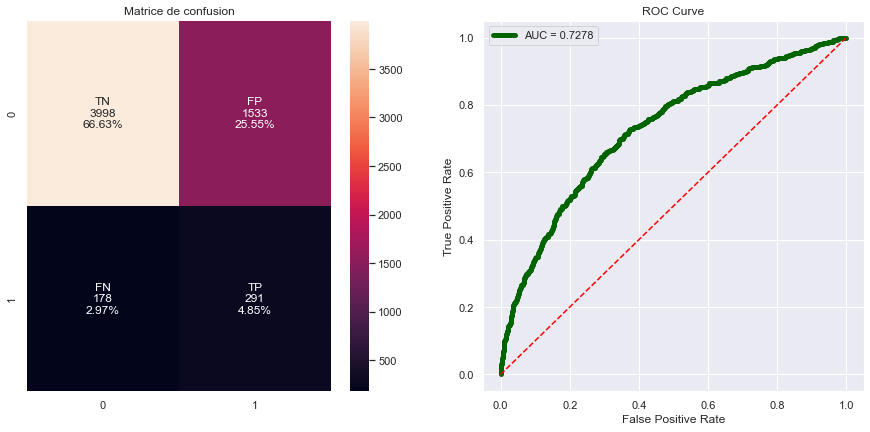

In [103]:
# Calculating the associated confusion matrix predictions and visualisation of the matrix and AUC/ROC
tn, fp, fn, tp = matrice_roc_auc(y_test, prediction, probability, (15,15))

# <a name="C10">Gains Optimisation</a>

In [104]:
# Calculating the Bank gain percentage with 10% profit assumptions for NW and 60% loss for FN, and considering modeling predictions with a classification threshold of 50%
gain = gain_banque(tn, fp, fn, tp, 0.10, 0, -0.6, 0)
gain

0.6883163571000599

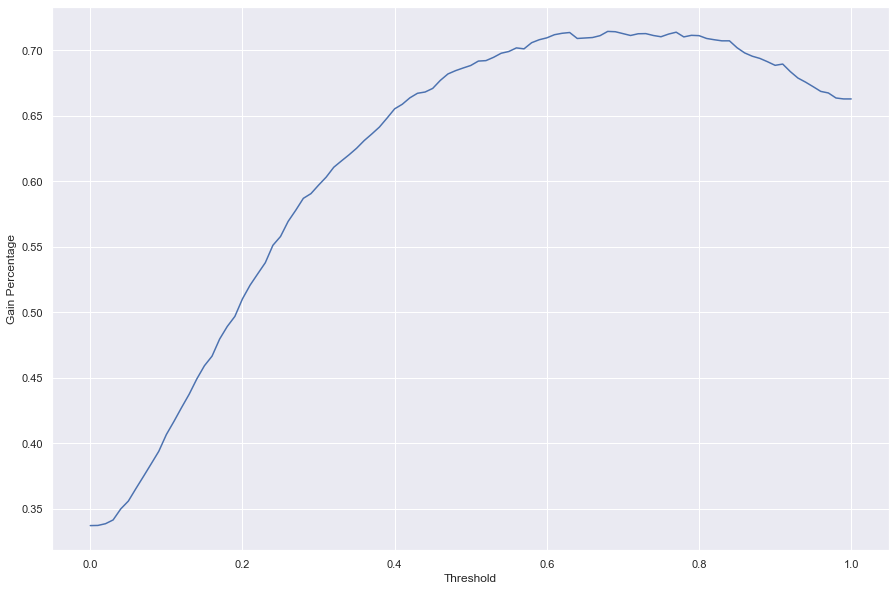

In [105]:
# Displaying the evolution of the bank's gain according to the chosen classification threshold
f_gain = []
int_seuil = np.arange(0.0, 1.01, 0.01)

for s in int_seuil:
    # Score du modèle : 0 à 1
    y_seuil=[]

    for i in probability_default_payment:
        if i >= s:
            y_seuil.append(1)
        elif i < s:
            y_seuil.append(0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()
  
    f_gain.append(gain_banque(tn, fp, fn, tp, 0.10, 0, -0.6, 0))
    
# Displaying the gain function based on the threshold  
plt.figure(figsize=(15, 10))
df_gain = pd.DataFrame()
df_gain['seuil'] = int_seuil
df_gain['gain'] =  f_gain
best_gain = df_gain['gain'].max()
best_seuil = df_gain[df_gain['gain']==best_gain]['seuil'].values[0]
plt.plot(int_seuil, f_gain)
plt.xlabel("Threshold")
plt.ylabel("Gain Percentage")
plt.show()

In [106]:
# Finding the best threshold
best_seuil = df_gain[df_gain['gain']==best_gain]['seuil'].values[0]
best_seuil

0.68

# <a name="C11">Model Interpretability</a>

In [107]:
# Renaming columns for better understanding of variables on the dashboard
info_cols = {
            'CODE_GENDER': "GENRE",
            'DAYS_BIRTH': "AGE",
            'NAME_FAMILY_STATUS': "STATUT FAMILIAL", 
            'CNT_CHILDREN': "NB ENFANTS",
            'FLAG_OWN_CAR': "PROPRIETAIRE VEHICULE",
            'FLAG_OWN_REALTY': "PROPRIETAIRE IMMOBILIER",
            'NAME_EDUCATION_TYPE': "NIVEAU EDUCATION",
            'OCCUPATION_TYPE': "OCCUPATION", 
            'DAYS_EMPLOYED': "NB ANNEES EMPLOI",
            'AMT_INCOME_TOTAL': "REVENUS",
            'AMT_CREDIT': "MONTANT CREDIT", 
            'NAME_CONTRACT_TYPE': "TYPE CONTRAT",
            'AMT_ANNUITY': "MONTANT ANNUITES",
            'NAME_INCOME_TYPE': "TYPE REVENUS",
            'EXT_SOURCE_1': "SCORE SOURCE 1",
            'EXT_SOURCE_2': "SCORE SOURCE 2",
            'EXT_SOURCE_3': "SCORE SOURCE 3",
            'INSTAL_DPD_MEAN' : "MOY DELAI PAIEMENT",
            'PAYMENT_RATE' : "TAUX PAIEMENT",
            'INSTAL_AMT_INSTALMENT_MEAN' : "DUREE MOYENNE CREDIT",
            'OWN_CAR_AGE' : "AGE VEHICULE",
            'APPROVED_CNT_PAYMENT_MEAN' : "MOYENS PAIEMENT",
            'ANNUITY_INCOME_PERC' : "% ANNUITE REVENU"
                }

In [108]:
# Renaming the columns
X.rename(columns=info_cols, inplace=True)

In [109]:
# Limiting to the first 100 customers on the list for SHAP calculation - to ensure quick display.
X_reduced = X.head(100)

### Global interpretation

In [110]:
# Computing SHAP global values
explainer = shap.TreeExplainer(best_model)
shap_values_g = explainer.shap_values(X)
shap_values_g

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[array([[-0.02220945,  0.        ,  0.04824055, ...,  0.        ,
          0.        ,  0.        ],
        [-0.06450883,  0.        ,  0.04565408, ...,  0.        ,
          0.        ,  0.        ],
        [-0.12668442,  0.        ,  0.07761397, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.05201522,  0.        ,  0.07055424, ...,  0.        ,
          0.        ,  0.        ],
        [-0.09500616,  0.        ,  0.06937538, ...,  0.        ,
          0.        ,  0.        ],
        [-0.1058591 ,  0.        ,  0.06365667, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.02220945,  0.        , -0.04824055, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.06450883,  0.        , -0.04565408, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.12668442,  0.        , -0.07761397, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.05201522,  0.        , -0.07055424, ...,  

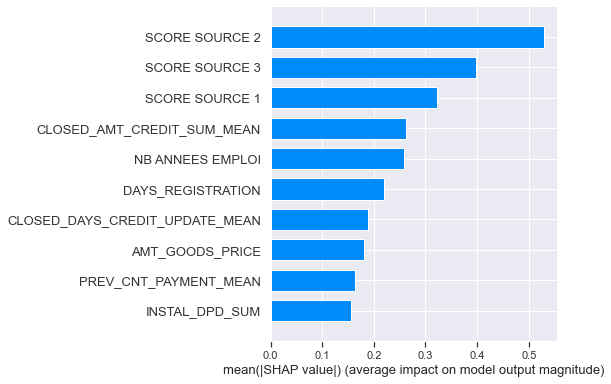

In [113]:
# Displaying of the most influential variables on the prediction
fig = plt.figure( )
shap.summary_plot(shap_values_g[0], plot_type = 'bar', feature_names = X.columns, max_display=10)
fig.savefig('Data/global_feature_importance.png', bbox_inches='tight', dpi=150)
plt.show()

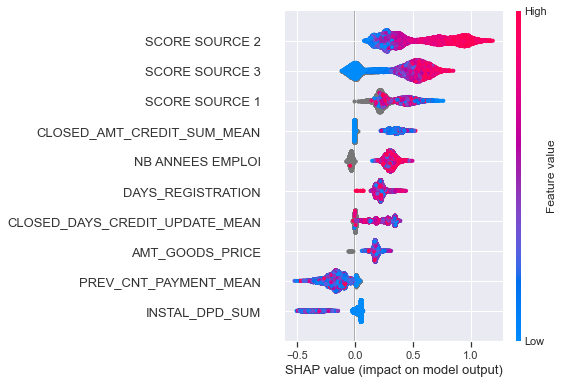

In [114]:
# Displaying of the most influential variables on the prediction
shap.summary_plot(shap_values_g[0], X.astype("float"),max_display=10, show=False)

### Local interpretation

In [115]:
# Computing SHAP values
explainer = shap.Explainer(best_model, X_reduced)
shap_values_l = explainer(X_reduced, check_additivity=False)
shap_values_l

.values =
array([[-2.73315053e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.47875762e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.47875762e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 5.47875762e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.95163661e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.82625260e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

.base_values =
array([-1.07609632, -1.07609632, -1.07609632, -1.07609632, -1.07609632,
       -1.07609632, -1.07609632, -1.07609632, -1.07609632, -1.07609632,
       -1.07609632, -1.07609632, -1.07609632, -1.07609632, -1.07609632,
 

In [116]:
# Activating SHAP to generate specific graphs
shap.initjs()

In [117]:
# # Displaying the most influential variables on the prediction of client 4 in the form of a force plot
shap.force_plot(explainer.expected_value, shap_values_l.values[4, :], X_reduced.iloc[3, :])

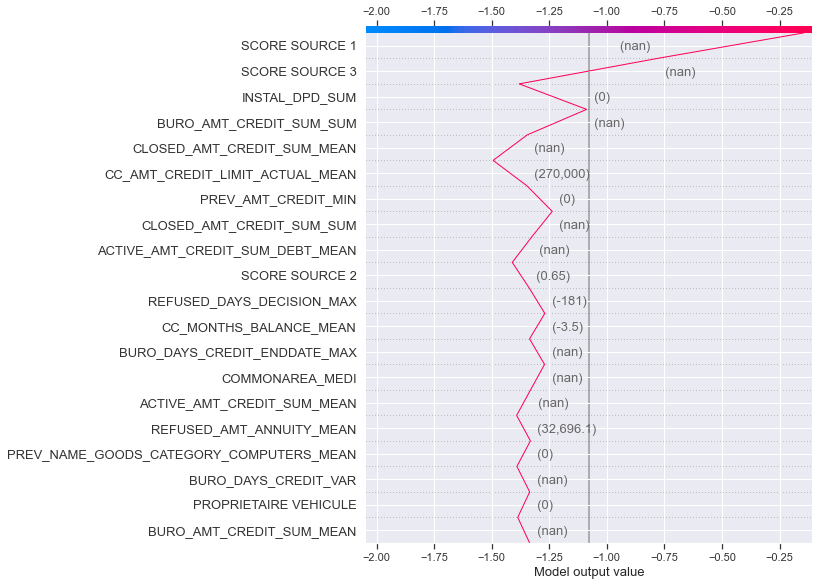

In [118]:
# Displaying the most influential variables on the prediction of client 4 in the form of a decision plot
shap.decision_plot(explainer.expected_value, shap_values_l.values[3, :], X_reduced.iloc[3, :])

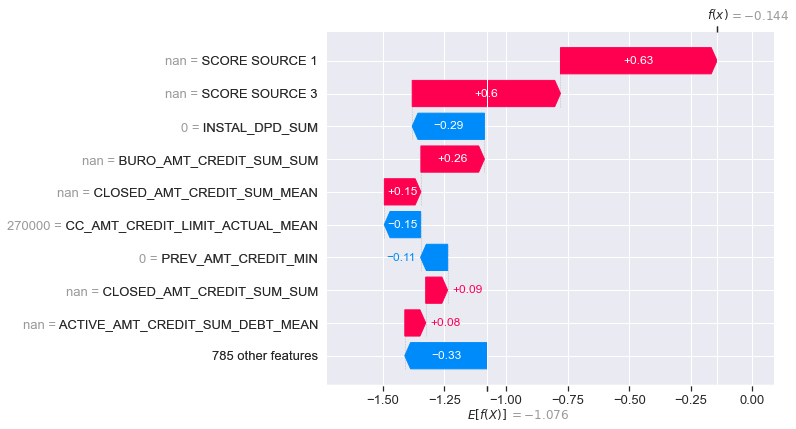

In [119]:
# Displaying the most influential variables on the prediction of client 4 in the form of a waterfall
shap.waterfall_plot(shap_values_l[3])

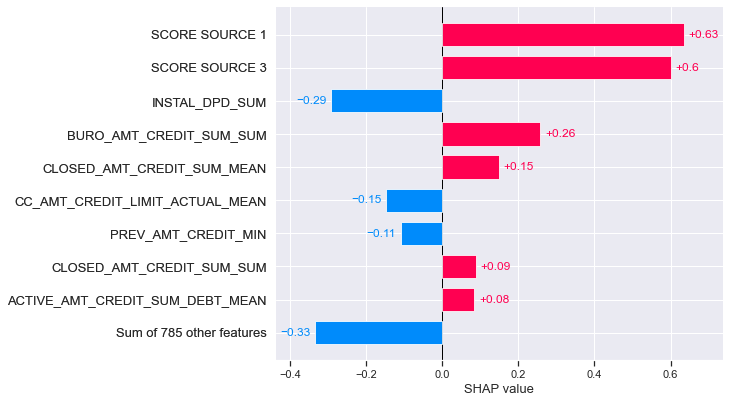

In [120]:
# Displaying the most influential variables on the prediction of client 4 in the form of a barplot
shap.plots.bar(shap_values_l[3])

# Part 3 : Dashboard

# <a name="C12">Model Deployment</a>

In [123]:
# Saving the best model
pickle.dump(best_model, open("Data/best_model.pkl", "wb"))

In [124]:
# Saving the optimal threshold
pickle.dump(best_seuil, open("Data/best_threshold.pkl", "wb"))

In [125]:
# Saving the data_train reduced to the first 100 customers - to display customer information
df_train_or = df_train_or.head(100)
df_train_or.to_csv('Data/df_train_reduced.csv', index=False)

In [126]:
# Saving the complex dataset reduced to the first 100 customers - for prediction and interpretation of the score
data = data.head(100)
data.to_csv('Data/df_kernel_reduced.csv', index=False)

In [127]:
#The end of the notebook